## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

https://timm.fast.ai/


In [47]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [48]:
from dotenv import load_dotenv
from datetime import datetime
from zoneinfo import ZoneInfo
import wandb

load_dotenv()
api_key = os.getenv('WANDB_API_KEY')

wandb.login(key=api_key)

train_time = datetime.fromtimestamp(time.time(), tz=ZoneInfo("Asia/Seoul")).strftime("%Y%m%d-%H%M%S")
wandb.init(project="competition2-cv", name=f"run-{train_time}")

print(train_time)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


20240802-190251


In [49]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'datasets_fin/'

# model config
model_name = 'efficientnet_b3.ra2_in1k' # 'resnet50' 'efficientnet-b0', ...

# training config
trn_img_size = 288
tst_img_size = 320
LR = 1e-3
EPOCHS = 5
BATCH_SIZE = 32
num_workers = 0
augment_ratio = 20

wandb.config.update({
    "learning_rate": LR,
    "architecture": model_name,
    "dataset": "custom-dataset",
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "train_image_size": trn_img_size,
    "test_image_size": tst_img_size,
    'augment_ratio' : augment_ratio,
})

In [50]:
# 시드를 고정합니다.
SEED = 42

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

set_seed(SEED)

In [51]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None, aug_transform=None, augment_ratio=1):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform
        self.aug_transform = aug_transform
        self.augment_ratio = augment_ratio

    def __len__(self):
        return len(self.df) * self.augment_ratio

    def __getitem__(self, idx):
        real_idx = idx % len(self.df)
        name, target = self.df[real_idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        
        if idx >= len(self.df):
            assert self.aug_transform != None
            img = self.aug_transform(image=img)['image']
            
        elif self.transform:
            img = self.transform(image=img)['image']
            
        return img, target

In [52]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    # seed 를 다시 고정해서 동일한 augmentation 된 이미지로 학습 될 수 있도록 해보자.
    set_seed(SEED)
    
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        
        #print(f"------ preds's shape = {preds.shape},  targets's shape = {targets.shape}")
        #print(f"---------- preds = {preds},  targets = {targets}")
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }
    
    # wandb에 학습 과정 로그
    wandb.log(ret)

    return ret

In [53]:
device

device(type='cuda')

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [54]:
# augmentation을 위한 transform 코드
trn_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=trn_img_size, width=trn_img_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

trn_aug_transform = A.Compose([
    A.Resize(height=trn_img_size, width=trn_img_size),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 800.0), p=0.75),
        A.GaussianBlur(blur_limit=(1, 7), p=0.5)
    ], p=0.75),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.75),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.25),
    A.CoarseDropout(max_holes=6, max_height=32, max_width=32, p=0.5),
    A.ElasticTransform(alpha=1, sigma=30, alpha_affine=30, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Rotate(limit=30, p=0.75),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
    A.MotionBlur(blur_limit=5, p=0.5),
    A.OpticalDistortion(p=0.5),
    A.Transpose(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# aug_p = 0.1
# trn_aug_transform = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.HorizontalFlip(p=aug_p),
#     A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=aug_p),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=aug_p),
#     A.CoarseDropout(max_holes=6, max_height=32, max_width=32, p=aug_p),
#     A.ElasticTransform(alpha=1, sigma=30, alpha_affine=30, p=aug_p),
#     A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=aug_p),
#     A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=aug_p),
#     A.Rotate(limit=(0, 360), p=1),
#     A.InvertImg(p=aug_p),
#     A.Solarize(threshold=128, p=aug_p),
#     #A.RandomCrop(height=img_size * 0.5, width=img_size * 0.5, p=aug_p),
#     A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=aug_p),
#     A.RandomGamma(gamma_limit=(80, 120), p=aug_p),
#     A.Posterize(num_bits=4, p=aug_p),
#     A.Equalize(p=aug_p),
#     A.GridDistortion(p=aug_p),
#     A.PiecewiseAffine(p=aug_p),
#     A.RandomShadow(p=aug_p),
#     A.RandomRain(p=aug_p),
#     A.RandomFog(p=aug_p),
#     A.RandomSunFlare(p=aug_p),
#     A.RandomSnow(p=aug_p),    
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=tst_img_size, width=tst_img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [55]:
# TODO target 분포를 고려해서 분할되도록..

def train_dataset_split(train_csv_path, img_dir, trn_transform, trn_aug_transform, tst_transform, augment_ratio=1, train_size=0.7, random_state=42):
    # CSV 파일 읽기
    train_df = pd.read_csv(train_csv_path)
    
    train_df_target = train_df['target']
    train_df = train_df['ID']
    
    # 훈련 세트와 검증 세트로 분할
    X_train, X_valid, y_train, y_valid = train_test_split(
        train_df, 
        train_df_target, 
        train_size=train_size, 
        stratify=train_df_target,
        random_state=random_state
    )
    
    print(f"[dataset_split] 훈련 세트: {len(X_train)} 샘플")
    print(f"[dataset_split] 검증 세트: {len(X_valid)} 샘플")
    
    train_df = pd.DataFrame({'ID':X_train, 'target':y_train})
    val_df = pd.DataFrame({'ID':X_valid, 'target':y_valid})
    
    # 각 데이터프레임을 임시 CSV 파일로 저장
    train_df.to_csv('temp_train.csv', index=False)
    val_df.to_csv('temp_val.csv', index=False)
    
    # ImageDataset 생성
    train_dataset = ImageDataset(
        'temp_train.csv', 
        img_dir, 
        transform=trn_transform, 
        aug_transform=trn_aug_transform, 
        augment_ratio=augment_ratio)
    
    val_dataset = ImageDataset(
        'temp_val.csv', 
        img_dir, 
        transform=tst_transform)
    
    # 임시 파일 삭제
    os.remove('temp_train.csv')
    os.remove('temp_val.csv')
    
    return train_dataset, val_dataset

In [56]:
# Dataset 정의

trn_dataset, val_dataset = train_dataset_split(
    "datasets_fin/train.csv",
    "datasets_fin/train/",
    trn_transform = trn_transform,
    trn_aug_transform = trn_aug_transform,
    tst_transform = tst_transform,
    augment_ratio = augment_ratio
)

tst_dataset = ImageDataset(
    "datasets_fin/sample_submission.csv",
    "datasets_fin/test/",
    transform=tst_transform
)

print("최종", len(trn_dataset), len(val_dataset), len(tst_dataset))

[dataset_split] 훈련 세트: 1099 샘플
[dataset_split] 검증 세트: 471 샘플
최종 21980 471 3140


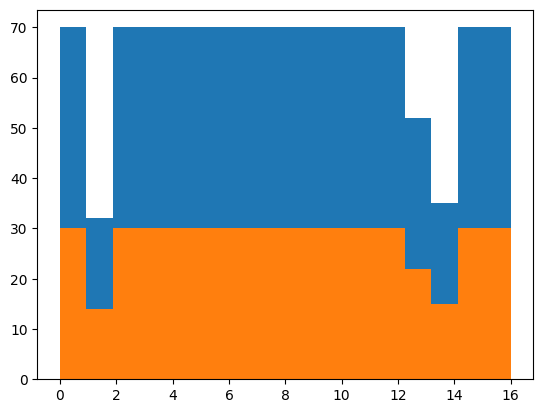

In [57]:
import matplotlib.pyplot as plt
plt.hist(trn_dataset.df[:,1], bins=17)
plt.hist(val_dataset.df[:,1], bins=17)
plt.show()

In [58]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,               # TODO ??????
    num_workers=num_workers,    # TODO ??????
    pin_memory=True,            # TODO ??????
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [59]:
len(timm.list_models(pretrained=True))

1298

In [60]:
timm.list_models('efficientnet*', pretrained=True)

['efficientnet_b0.ra_in1k',
 'efficientnet_b1.ft_in1k',
 'efficientnet_b1_pruned.in1k',
 'efficientnet_b2.ra_in1k',
 'efficientnet_b2_pruned.in1k',
 'efficientnet_b3.ra2_in1k',
 'efficientnet_b3_pruned.in1k',
 'efficientnet_b4.ra2_in1k',
 'efficientnet_b5.sw_in12k',
 'efficientnet_b5.sw_in12k_ft_in1k',
 'efficientnet_el.ra_in1k',
 'efficientnet_el_pruned.in1k',
 'efficientnet_em.ra2_in1k',
 'efficientnet_es.ra_in1k',
 'efficientnet_es_pruned.in1k',
 'efficientnet_lite0.ra_in1k',
 'efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k']

In [61]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [62]:
for epoch in range(EPOCHS):
    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
    ret['epoch'] = epoch

    log = ""
    for k, v in ret.items():
      log += f"{k}: {v:.4f}\n"
    print(log)

Loss: 0.0132: 100%|██████████| 687/687 [10:06<00:00,  1.13it/s]


train_loss: 0.3393
train_acc: 0.8822
train_f1: 0.8744
epoch: 0.0000



Loss: 0.0886: 100%|██████████| 687/687 [10:08<00:00,  1.13it/s]


train_loss: 0.0969
train_acc: 0.9665
train_f1: 0.9648
epoch: 1.0000



Loss: 0.0017: 100%|██████████| 687/687 [10:07<00:00,  1.13it/s]


train_loss: 0.0791
train_acc: 0.9726
train_f1: 0.9716
epoch: 2.0000



Loss: 0.0080: 100%|██████████| 687/687 [10:06<00:00,  1.13it/s]


train_loss: 0.0651
train_acc: 0.9778
train_f1: 0.9772
epoch: 3.0000



Loss: 0.0730: 100%|██████████| 687/687 [10:07<00:00,  1.13it/s]

train_loss: 0.0448
train_acc: 0.9849
train_f1: 0.9844
epoch: 4.0000



# 평가

In [63]:
def evaluate(loader, model, loss_fn, device=device):
    # seed 를 다시 고정해서 학습할때 사용했던 augmentation 이 사용될 수 있도록 수정.
    set_seed(SEED)

    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for image, targets in tqdm(loader, desc="Evaluating"):
            image = image.to(device)
            targets = targets.to(device)

            preds = model(image)
            loss = loss_fn(preds, targets)

            total_loss += loss.item()
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')

    # wandb에 평가 메트릭 로깅
    results = {
        "loss": avg_loss,
        "accuracy": accuracy,
        "f1": f1
    }
    #wandb.log(results)

    return avg_loss, accuracy, f1

train_results = evaluate(trn_loader, model, loss_fn)
valid_results = evaluate(val_loader, model, loss_fn)

# 평가 결과 로깅
log_dict = {
    "final_train_loss": train_results[0],
    "final_train_accuracy": train_results[1],
    "final_train_f1": train_results[2],
    "final_valid_loss": valid_results[0],
    "final_valid_accuracy": valid_results[1],
    "final_valid_f1": valid_results[2],
}

wandb.log(log_dict)

print()
for k, v in log_dict.items():
    print(f'{k}: {v}')

Evaluating: 100%|██████████| 15/15 [00:02<00:00,  5.64it/s]


final_train_loss: 0.04067016506755671
final_train_accuracy: 0.9859417652411283
final_train_f1: 0.9859558880127104
final_valid_loss: 0.40262049658340404
final_valid_accuracy: 0.9150743099787686
final_valid_f1: 0.9105627020873613


# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [64]:
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:17<00:00,  5.54it/s]


In [65]:
tst_dataset.df.shape

(3140, 2)

In [66]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [67]:
pred_df

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,13
4,00901f504008d884.jpg,2
...,...,...
3135,ffb4b6f619fb60ea.jpg,6
3136,ffb54299b1ad4159.jpg,10
3137,ffc2c91dff8cf2c0.jpg,8
3138,ffc4e330a5353a2a.jpg,0


In [68]:
sample_submission_df = pd.read_csv("datasets_fin/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [69]:
pred_df.to_csv("pred.csv", index=False)

In [70]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,13
4,00901f504008d884.jpg,2


In [71]:
# wandb 실행 종료
wandb.finish()

final_train_accuracy,▁
final_train_f1,▁
final_train_loss,▁
final_valid_accuracy,▁
final_valid_f1,▁
final_valid_loss,▁
train_acc,▁▇▇██
train_f1,▁▇▇██
train_loss,█▂▂▁▁
final_train_accuracy,0.98594
final_train_f1,0.98596
